Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [19]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from icecream import ic

In [18]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

NameError: name 'NUM_SETS' is not defined

## Definitive solution
Speedup is required. Use a state of covered elements (analog of what done in greedy approach) to keep track of current coverage for each element in the universe.
Using:
- multiple mutation tweak
- heuristic to limit research space
- random start ?
- simulated annealing with self-adaptive parameter ?

### Data

In [20]:
universe_sizes = [100, 1000, 10_000, 100_000, 100_000, 100_000]
num_sets_sizes = [10, 100, 1000, 10_000, 10_000, 10_000]
densities = [.2, .2, .2, .1, .2, .3]

#### Generator function

In [21]:
def generate_data(universe_size, num_sets, density):
    SETS = np.random.random((num_sets, universe_size)) < density
    for s in range(universe_size):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(num_sets), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)
    
    return SETS, COSTS

### Helper functions

In [22]:
def init_sol(sets: np.ndarray) -> np.ndarray:
    less_covered_elem = np.argmin(sets.sum(axis=0))
    solution = np.logical_not(sets[:, less_covered_elem])
    
    return solution

def valid(sets, solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(sets[solution])     # at least each element covered by a set
    return np.all(phenotype)                             # all elements are covered

def coverage(sets, solution):
    """Returns the number of covered elements in the universe"""
    phenotype = np.logical_or.reduce(sets[solution])    # at least each element covered by a set
    return np.sum(phenotype)                            # number of covered elements    

def cost(costs, solution):
    """Returns the cost of a solution (to be minimized)"""
    return costs[solution].sum()

def fitness(covering: np.ndarray, costs: np.ndarray, solution: np.ndarray):
    """Returns the fitness of the given solution"""
    return (np.sum(covering > 0), -cost(costs, solution))

# Based on Vincenzo Avantaggiato's version
def tweak(solution: np.ndarray, covering: np.ndarray, sets: np.ndarray) -> np.ndarray:
    """Uses a single mutation method"""
    
    new_sol = solution.copy()
    
    index = np.random.randint(0, solution.shape[0])    
    new_sol[index] = not new_sol[index]
    
    modification = 2*new_sol[index]-1
    
    # Rollbacks the modification (if it is a removal): not allowed to remove a set from the solution
    # if its removal causes an element to become uncovered
    if modification == -1 and np.sum(covering[sets[index]] <= 1):
        return solution
        
    # Store the number of sets covering each element in the universe
    covering += modification * sets[index]
    
    """
    mask = np.random.random(solution.shape[0])
    
    new_sol = np.logical_xor(solution, mask)
    
    # Get value of previous solutions whose value changed from 1 to 0
    removed = np.logical_and(solution, mask)
    
    # Get value of previous solutions whose value changed from 0 to 1
    added = np.logical_and(np.logical_not(solution), mask)
    
    removed_mask = np.sum(np.logical_and(sets, removed.reshape(removed.shape[0], 1)), axis=0)
    
    if np.any(np.sum(covering[removed_mask] <= 1, axis=0)):
        return solution
    
    covering += np.sum(np.logical_and(sets, added.reshape(added.shape[0], 1)), axis=0)
    covering -= removed_mask
    """
    return new_sol

In [35]:
def solve_set_cover(sets: np.ndarray, costs: np.ndarray, num_steps: int = 10_000, buf_size: int = 5, init_strength: float = 0.5):
    
    num_sets = sets.shape[0]
    universe_size = sets.shape[1]
    
    solution = init_sol(sets)
    best_cov = np.sum(sets[solution], axis=0)
    sol_fitness = fitness(best_cov, costs, solution)
    history = [float(sol_fitness[1])]
    
    # Initially, first valid index is 0 if starting solution is valid , otherwise it is -1
    first_valid = int(sol_fitness[0] == universe_size) - 1
    for i in tqdm(range(num_steps)):
        curr_cov = best_cov.copy()
        current = tweak(solution.copy(), curr_cov, sets)
        
        curr_fitness = fitness(curr_cov, costs, current)
        history.append(float(curr_fitness[1]))
        
        # Mark current index as first valid (index 0 is the initial solution)
        first_valid = i+1 if curr_fitness[0] == universe_size and first_valid == -1 else first_valid
        
        #ic(curr_fitness)
        
        if curr_fitness > sol_fitness:
            sol_fitness = curr_fitness
            solution = current
            best_cov = curr_cov
            
    ic(first_valid)
            
    plt.figure(figsize=(14,8))
    plt.plot(
        range(0, first_valid),
        list(accumulate(history[: first_valid], min)),
        color="red",
    )
    plt.plot(
        range(first_valid, len(history)),
        list(accumulate(history[first_valid :], max)),
        color="red",
    )
    plt.scatter(range(len(history)), history, marker=".", color="blue")
    
    ic(sol_fitness)
    ic(history.index(float(sol_fitness[1])))
    
    #ic(np.sum(sets[solution],axis=1))
    
    return solution, sol_fitness
    

### Greedy approach
For each iteration, we collect the set that covers the larger number of still uncovered elements. The iterations continue until complete universe coverage is reached.

In [24]:
def solve_greedy(sets: np.ndarray, costs: np.ndarray, num_sets) -> np.ndarray:
    
    solution = np.full(num_sets, False)
    set_matrix = sets.copy()
    covered = 0

    while covered < set_matrix.shape[1]:
        
        progress = 100 * covered / set_matrix.shape[1]
        print(float(progress), end=" ")
        
        largest_index = np.argmax(set_matrix.sum(axis=1))
        largest = set_matrix[largest_index, :]
        solution[largest_index] = True
        covered += largest.sum()
        
        # For each row of the matrix, set to False the corresponding column if the cell of the "largest" vector is True
        # Given the vector corresponding to the coverings for the larger set (to collect),
        # it removes all possible coverings for those elements covered by this set,
        # in order to ignore them in next steps
        set_matrix *= np.logical_not(largest)
                
    print()
    
    sol_fitness = fitness(np.sum(sets[solution], axis=0), costs, solution)
    
    return solution, sol_fitness

#### Solver caller
Calls solve function for each required instance. 

ic| f"Generating instance {i+1}": 'Generating instance 1'
ic| f"Solving instance {i+1}": 'Solving instance 1'


  0%|          | 0/1000 [00:00<?, ?it/s]

ic| first_valid: 13
ic| sol_fitness: (np.int64(100), np.float64(-288.2686146035592))
ic| history.index(float(sol_fitness[1])): 13
ic| sol_state: np.int64(100)
    sol_fitness: np.float64(-288.2686146035592)
ic| greedy_state: np.int64(100)
    greedy_fitness: np.float64(-288.2686146035592)
ic| f"Generating instance {i+1}": 'Generating instance 2'
ic| 

0.0 28.0 47.0 61.0 72.0 80.0 87.0 92.0 95.0 98.0 


f"Solving instance {i+1}": 'Solving instance 2'


  0%|          | 0/1000 [00:00<?, ?it/s]

ic| first_valid: 62
ic| sol_fitness: (np.int64(1000), np.float64(-7277.588076307864))
ic| history.index(float(sol_fitness[1])): 423
ic| sol_state: np.int64(1000)
    sol_fitness: np.float64(-7277.588076307864)
ic| greedy_state: np.int64(1000)
    greedy_fitness: np.float64(-6085.479927344133)
ic| f"Generating instance {i+1}": 'Generating instance 3'


0.0 23.2 40.7 54.3 65.1 73.4 79.9 84.9 88.9 92.2 94.6 96.4 97.7 98.7 99.2 99.5 99.8 


ic| f"Solving instance {i+1}": 'Solving instance 3'


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| first_valid: 47
ic| sol_fitness: (np.int64(10000), np.float64(-132593.69451160435))
ic| history.index(float(sol_fitness[1])): 3760


0.0 21.26 38.25 51.78 62.42 70.72 77.22 82.47 86.63 89.84 92.24 94.09 95.53 96.72 97.59 98.26 98.76 99.16 

ic| sol_state: np.int64(10000)
    sol_fitness: np.float64(-132593.69451160435)
ic| greedy_state: np.int64(10000)
    greedy_fitness: np.float64(-105106.43658707765)


99.45 99.66 99.8 99.89 99.96 99.99 


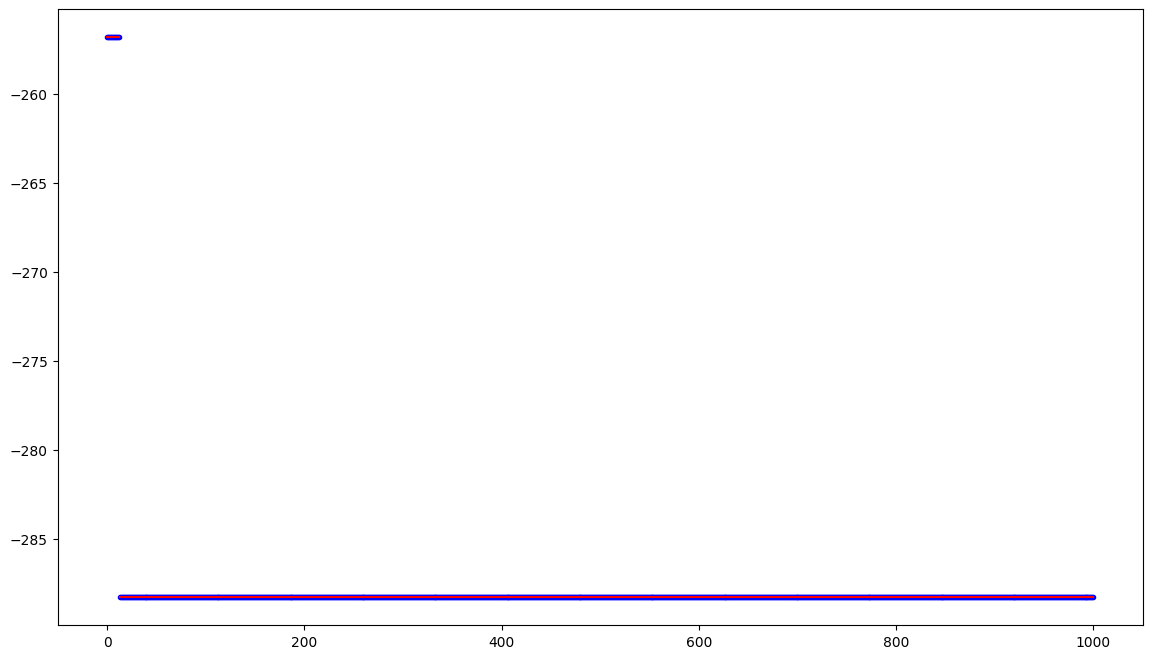

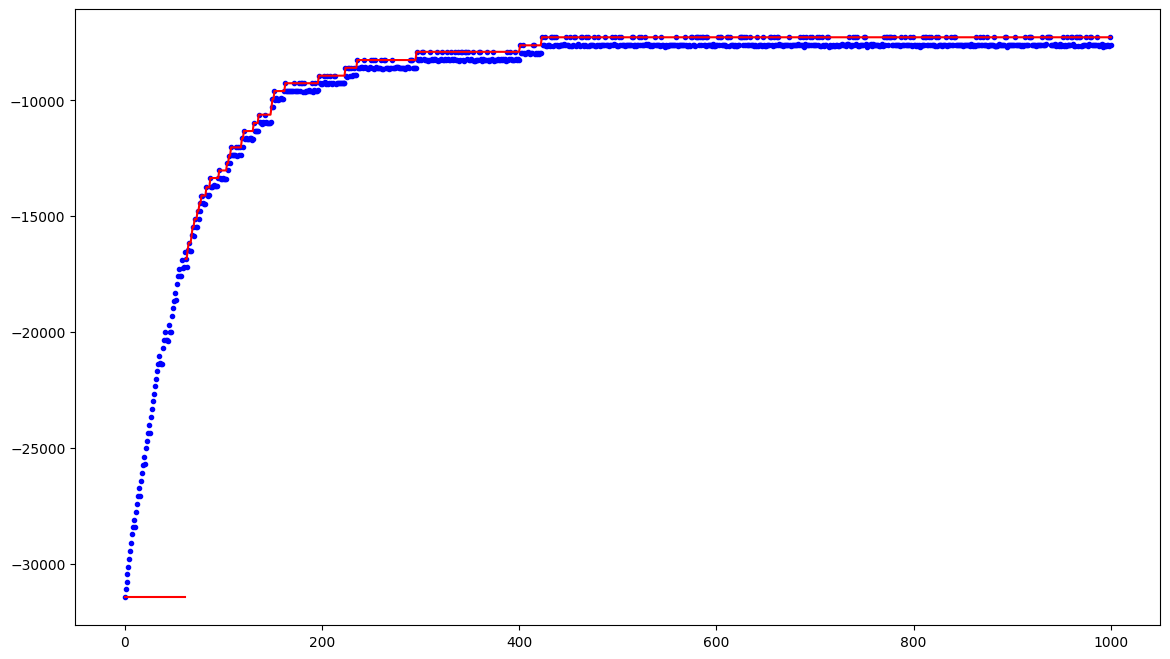

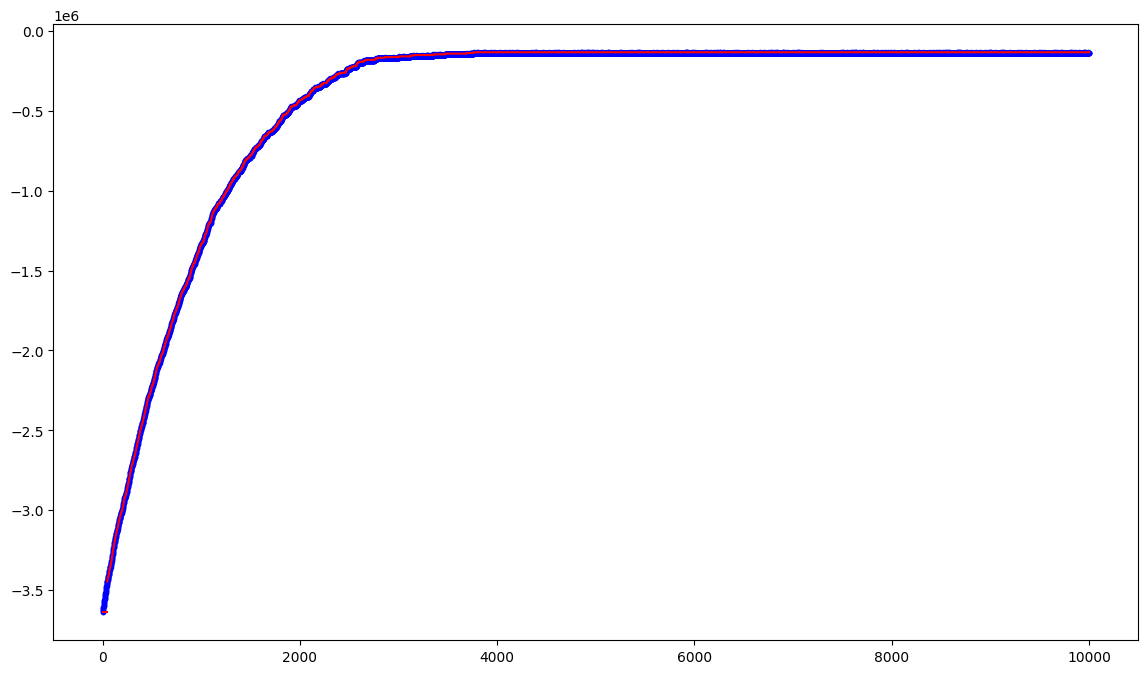

In [36]:
NUM_INSTANCES = len(universe_sizes)

# Useful for debugging
MIN_INSTANCE = 1
MAX_INSTANCE = 3

for (i, (universe_size, num_sets, density)) in \
    list(enumerate(zip(universe_sizes, num_sets_sizes, densities))) [MIN_INSTANCE-1 : MAX_INSTANCE]:

    ic(f"Generating instance {i+1}")

    sets, costs = generate_data(universe_size, num_sets, density)
    
    num_steps = 100_000 if i > 2 else (10_000 if i == 2 else 1000)

    ic(f"Solving instance {i+1}")
    
    solution, (sol_state, sol_fitness) = solve_set_cover(sets, costs, num_steps=num_steps)
    greedy_sol, (greedy_state, greedy_fitness) = solve_greedy(sets, costs, num_sets)
    
    ic(sol_state, sol_fitness)
    ic(greedy_state, greedy_fitness)
    